# Distributed hyper-parameter optimization with the Cray HPO library

In this notebook we demonstrate distributed HPO with multi-node training using the Cray HPO library for the RPV classification problem.

In [36]:
!squeue -u $USER

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)


In [2]:
# System
import sys
import glob

# Externals
import pandas as pd
import matplotlib.pyplot as plt

# Pick up local installation of Cray-HPO
sys.path.append('/global/cscratch1/sd/sfarrell/cray-hpo/software')
from crayai import hpo

## Configure the search

In [3]:
# Job config
n_nodes = 16
nodes_per_eval = 1
alloc_args = '-J cray-hpo-rpv -q interactive -C haswell -t 4:00:00 -c 64'

In [4]:
# Training config
n_epochs = 4

In [5]:
# Optimizer config
pop_size = 8
num_demes = 4
generations = 4
mutation_rate = 0.05
crossover_rate = 0.33
results_file = 'hpo.log'

In [6]:
# Hyperparameters
params = hpo.Params([
    ['--h1', 16, (4, 64)],
    ['--h2', 32, (4, 64)],
    ['--h3', 64, (8, 128)],
    ['--h4', 128, (32, 256)],
    ['--dropout', 0.2, (0., 1.)],
    ['--optimizer', 'Adam', ['Adam', 'Nadam', 'Adadelta']],
    ['--lr', 1e-3, [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]],
])

## Perform the search

In [7]:
# Define the evaluator
cmd = 'python train_rpv.py --n-epochs %i --fom best' % (n_epochs)
evaluator = hpo.Evaluator(cmd,
                          nodes=n_nodes,
                          nodes_per_eval=nodes_per_eval,
                          alloc_args=alloc_args,
                          launcher='wlm',
                          verbose=True)

In [8]:
# Define the optimizer
optimizer = hpo.GeneticOptimizer(evaluator,
                                 pop_size=pop_size,
                                 num_demes=num_demes,
                                 generations=generations,
                                 mutation_rate=mutation_rate,
                                 crossover_rate=crossover_rate,
                                 verbose=True,
                                 log_fn=results_file)

In [ ]:
%%time

# Run the optimizer
optimizer.optimize(params)

In [ ]:
# Destruct the evaluator to release the allocation
del evaluator
# Delete the optimizer to make it dump out the full Deme results
del optimizer

## Analyze the results

In [17]:
# Summary table for each generation
summary = pd.read_csv(results_file, delim_whitespace=True)
summary

,generation,epoch,best_fom,avg_fom,checkpoint_in,checkpoint_out,--h1,--h2,--h3,--h4,--dropout,--optimizer,--lr
0,0,1,0.053746,1.030859,NaN,NaN,17,33,62,127,0.178378,Nadam,0.001
1,1,2,0.053746,0.478970,NaN,NaN,17,33,62,127,0.178378,Nadam,0.001
2,2,3,0.052650,0.459193,NaN,NaN,17,33,53,127,0.193145,Nadam,0.001
3,3,4,0.051910,0.874282,NaN,NaN,17,33,62,114,0.178378,Adam,0.001


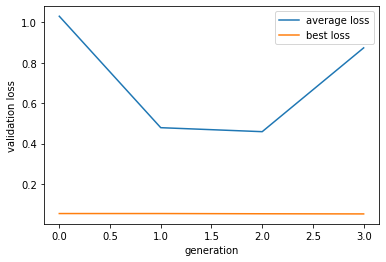

In [25]:
# Plot the figure of merit as a function of generation
plt.figure()
plt.plot(summary.generation, summary.avg_fom, label='average loss')
plt.plot(summary.generation, summary.best_fom, label='best loss')
plt.xlabel('generation')
plt.ylabel('validation loss')
plt.legend(loc=0);

In [26]:
# Load all of the HPO search results
deme_results = [pd.read_csv('Deme%i_%s' % (deme, results_file), delim_whitespace=True)
                for deme in range(1, num_demes+1)]
results = pd.concat(deme_results, ignore_index=True)

In [27]:
results

,generation,tag,fitness,FoM,--h1,--h2,--h3,--h4,--dropout,--optimizer,--lr
0,0,deme1_ind0,1.000000,0.055498,16,32,64,128,0.200000,Adam,0.00100
1,0,deme1_ind1,0.988828,0.289507,15,34,62,126,0.198051,Adadelta,0.10000
2,0,deme1_ind2,0.920076,0.692692,18,31,63,126,0.138825,Adadelta,0.00010
3,0,deme1_ind3,0.000045,7.037060,18,33,60,125,0.308221,Adam,0.10000
4,0,deme1_ind4,0.990487,0.271349,18,30,61,129,0.201012,Adam,0.00010
5,0,deme1_ind5,0.919720,0.694172,14,28,56,129,0.174126,Adadelta,0.00001
6,0,deme1_ind6,0.990978,0.265671,14,30,60,121,0.075203,Nadam,0.01000
7,0,deme1_ind7,0.988201,0.296027,19,31,63,121,0.171638,Adam,0.00001
8,1,deme1_ind9,0.994557,0.271194,18,30,61,126,0.201012,Adam,0.00010
9,1,deme1_ind10,0.000045,7.037060,14,34,60,121,0.198051,Nadam,0.10000


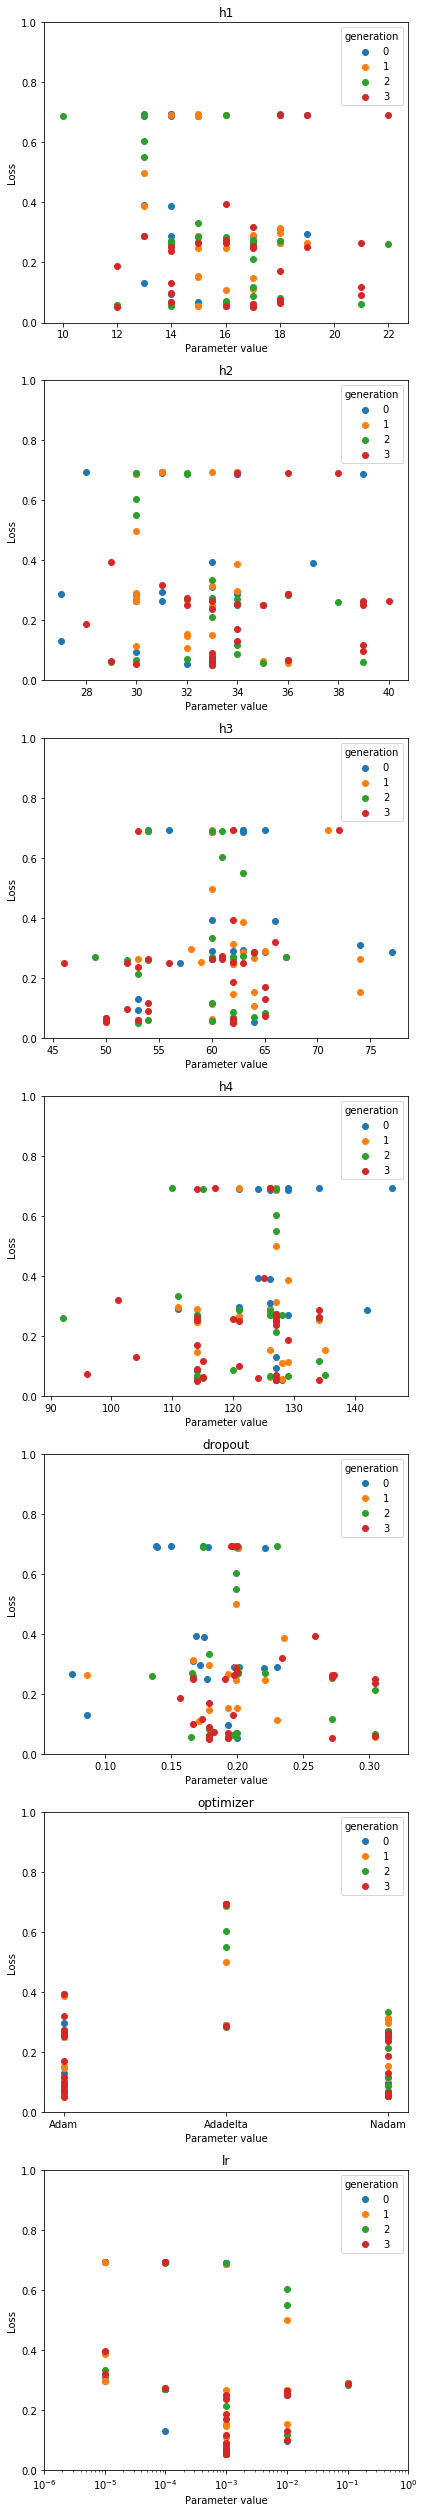

In [35]:
# Make scatter plots of the parameters
hps = ['h1', 'h2', 'h3', 'h4', 'dropout', 'optimizer', 'lr']
fig, axs = plt.subplots(nrows=len(hps), figsize=(6, 5 * len(hps)))

gen_groups = results.groupby('generation')
    
# Loop over HPs
for i, hp in enumerate(hps):
    
    # Loop over generations
    for gen in range(generations):
        gen_results = gen_groups.get_group(gen)
        axs[i].scatter(gen_results['--'+hp], gen_results.FoM, label=gen)
    
    # Finish the plot
    axs[i].set_title(hp)
    axs[i].set_xlabel('Parameter value')
    axs[i].set_ylabel('Loss')
    axs[i].set_ylim(bottom=0, top=1)
    axs[i].legend(title='generation', loc=0)
    
    if hp == 'lr':
        axs[i].set_xlim((1e-6, 1))
        axs[i].set_xscale('log')

plt.tight_layout()